<a href="https://colab.research.google.com/github/KarthikRaja-Selvan/MonetGAN/blob/main/MonetGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-addons
#!pip uninstall tensorflow
#!pip install tensorflow==2.8
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
os.chdir("drive/My Drive/gan-getting-started/")

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Device:', tpu.master())
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
  strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.8.0


In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [ ]:
IMAGE_SIZE = [256, 256]

#Loads a dataset from TFRecord files and applies the preprocessing (decoding) to each record.
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

#Decodes and normalizes a JPEG image from raw bytes to a tensor.
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

#Parses a serialized TFRecord, extracting and preprocessing the image.
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
monet_df = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_df = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

#Contains 1 image data
monet_sample = next(iter(monet_df))
photo_sample = next(iter(photo_df))

#Contains more than 1 image data
#monet_samples = next(iter(monet_df.batch(5)))
#photo_samples = next(iter(photo_df.batch(5)))

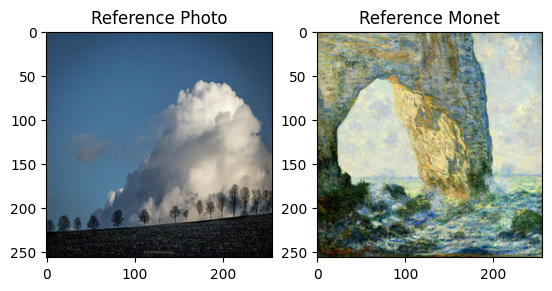

In [ ]:
plt.subplot(121)
plt.title('Reference Photo')
#plt.imshow(np.squeeze(photo_sample[0], axis=0)*0.5+0.5) #For photo_samples
plt.imshow(photo_sample[0]*0.5+0.5)


plt.subplot(122)
plt.title('Reference Monet')
#plt.imshow(np.squeeze(monet_sample[0], axis=0)*0.5+0.5) #For monet_samples
plt.imshow(monet_sample[0]*0.5+0.5)

# Build the generator
<b>Downsample: </b><br>Reduces the 2D dimensions, the width and height, of the image by the stride. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.
<br>
<br>
<b>Upsample: </b><br>Does the opposite of downsample and increases the dimensions of the of the image. Conv2DTranspose does basically the opposite of a Conv2D layer.

In [ ]:
output_channels = 3

#Downsample()
def downsample(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  result = keras.Sequential()
  result.add(layers.Conv2D(filters=filters, kernel_size=size, strides=2, padding='same',
                           kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

  result.add(layers.LeakyReLU())
  return result

#Upsample
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result = keras.Sequential()
  result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2, padding='same',
                                    kernel_initializer=initializer, use_bias=False))
  result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

  if apply_dropout:
    result.add(layers.Dropout(0.5))

  result.add(layers.ReLU())
  return result

In [ ]:
#Create Generator()
def Generator():
  inputs = layers.Input(shape=[256,256,3])

  down_stack = [downsample(64, 4, apply_instancenorm=False), #(, 128, 128, 64)
                downsample(128, 4), #(, 64, 64, 128)
                downsample(256, 4), #(, 32, 32, 256)
                downsample(512, 4), #(, 16, 16, 512)
                downsample(512, 4), #(, 8, 8, 512)
                downsample(512, 4), #(, 4, 4, 512)
                downsample(512, 4), #(, 2, 2, 512)
                downsample(512, 4), #(, 1, 1, 512)
                ]

  up_stack = [upsample(512, 4, apply_dropout=True), #(, 2, 2, 1024)
              upsample(512, 4, apply_dropout=True), #(, 4, 4, 1024)
              upsample(512, 4, apply_dropout=True), #(, 8, 8, 1024)
              upsample(512, 4), #(, 16, 16, 1024)
              upsample(256, 4), #(, 32, 32, 512)
              upsample(128, 4), #(, 64, 64, 256)
              upsample(64, 4), #(, 128, 128, 128)
              ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                kernel_initializer=initializer, activation='tanh') #(, 256, 256, 3)

  x = inputs

  #Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  #Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)

In [ ]:
#Create Discriminator()
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  inp = layers.Input(shape=[256, 256, 3], name='input_image')
  x = inp

  down1 = downsample(64, 4, False)(x) #(, 128, 128, 64)
  down2 = downsample(128, 4)(down1) #(, 64, 64, 128)
  down3 = downsample(256, 4)(down2) #(, 32, 32, 256)

  zero_pad1 = layers.ZeroPadding2D()(down3) #(, 34, 34, 256)
  conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                       use_bias=False)(zero_pad1) #(, 31, 31, 512)
  norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
  leaky_relu = layers.LeakyReLU()(norm1)
  zero_pad2 = layers.ZeroPadding2D()(leaky_relu) #(, 33, 33, 512)
  last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) #(, 30, 30, 1)

  return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
  monet_generator = Generator() #Transform photo -> monet painting
  photo_generator = Generator() #Transform monet painting -> photo

  monet_discriminator = Discriminator() #Differentiate real monet painting & generate monet painting
  photo_discriminator = Discriminator() #Differentiate real photo & generate photos

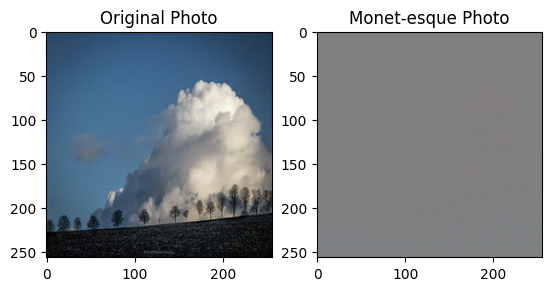

In [ ]:
#Results before training
to_monet = monet_generator(photo_sample)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(photo_sample[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

<h2> Build CycleGAN model </h2>

In [ ]:
class CycleGAN(keras.Model):
  def __init__(self, monet_generator, photo_generator,
               monet_discriminator, photo_discriminator, lambda_cycle=10,):
    super(CycleGAN, self).__init__()
    self.m_gen = monet_generator
    self.p_gen = photo_generator
    self.m_disc = monet_discriminator
    self.p_disc = photo_discriminator
    self.lambda_cycle = lambda_cycle

  def compile(self, m_gen_optimizer, p_gen_optimizer,
              m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn,
              cycle_loss_fn, identity_loss_fn):
    super(CycleGAN, self).compile()
    self.m_gen_optimizer = m_gen_optimizer
    self.p_gen_optimizer = p_gen_optimizer
    self.m_disc_optimizer = m_disc_optimizer
    self.p_disc_optimizer = p_disc_optimizer
    self.gen_loss_fn = gen_loss_fn
    self.disc_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def train_step(self, batch_data):
    real_monet, real_photo = batch_data

    with tf.GradientTape(persistent=True) as tape:
      #photo -> monet -> photo again
      fake_monet = self.m_gen(real_photo, training=True)
      cycled_photo = self.p_gen(fake_monet, training=True)

      #monet -> photo -> monet
      fake_photo = self.p_gen(real_monet, training=True)
      cycled_monet = self.m_gen(fake_photo, training=True)

      #generating itself
      same_monet = self.m_gen(real_monet, training=True)
      same_photo = self.p_gen(real_photo, training=True)

      #discriminator used to check, inputing real images
      disc_real_monet = self.m_disc(real_monet, training=True)
      disc_real_photo = self.p_disc(real_photo, training=True)

      #discriminator used to check, inputing fake images
      disc_fake_monet = self.m_disc(fake_monet, training=True)
      disc_fake_photo = self.p_disc(fake_photo, training=True)

      #evaluates generator loss
      monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
      photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

      #evaluates total cycle consistency loss
      total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

      #evaluates total generator loss
      total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
      total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

      #evaluates discriminator loss
      monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
      photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

      #calculate the gradients for generator and discriminator
      monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
      photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
      monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
      photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

      #apply the gradients to thje optimizer
      self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
      self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
      self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
      self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

      return {
          "monet_gen_loss": total_monet_gen_loss,
          "photo_gen_loss": total_photo_gen_loss,
          "monet_disc_loss": monet_disc_loss,
          "photo_disc_loss": photo_disc_loss
      }

<h2>Define Loss Functions</h2>

In [ ]:
#Discriminator Loss Function
with strategy.scope():
  def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                        reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [ ]:
#Generator Loss Function
with strategy.scope():
  def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                              reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
#Cycle Consistency Loss Function
with strategy.scope():
  def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycled_image))
    return LAMBDA * loss1

In [ ]:
#Identity Loss Function
with strategy.scope():
  def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image-same_image))
    return LAMBDA * 0.5 * loss

<h2>Train the CycleGAN </h2>

In [ ]:
with strategy.scope():
  monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
  photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
  cycle_gan_model = CycleGAN(monet_generator, photo_generator,
                             monet_discriminator, photo_discriminator)
  cycle_gan_model.compile(
      m_gen_optimizer = monet_generator_optimizer,
      p_gen_optimizer = photo_generator_optimizer,
      m_disc_optimizer = monet_discriminator_optimizer,
      p_disc_optimizer = photo_discriminator_optimizer,
      gen_loss_fn = generator_loss,
      disc_loss_fn = discriminator_loss,
      cycle_loss_fn = calc_cycle_loss,
      identity_loss_fn = identity_loss
  )

In [ ]:
cycle_gan_model.fit(tf.data.Dataset.zip((monet_df, photo_df)), epochs=25)

Epoch 1/25
300/300 [==============================] - 3483s 12s/step - monet_gen_loss: 3.5850 - photo_gen_loss: 3.8277 - monet_disc_loss: 0.6780 - photo_disc_loss: 0.5952
Epoch 2/25
300/300 [==============================] - 3428s 11s/step - monet_gen_loss: 3.5345 - photo_gen_loss: 3.7916 - monet_disc_loss: 0.6535 - photo_disc_loss: 0.5943
Epoch 3/25
174/300 [================>.............] - ETA: 23:59 - monet_gen_loss: 3.5595 - photo_gen_loss: 3.8071 - monet_disc_loss: 0.6473 - photo_disc_loss: 0.6025

KeyboardInterrupt: 

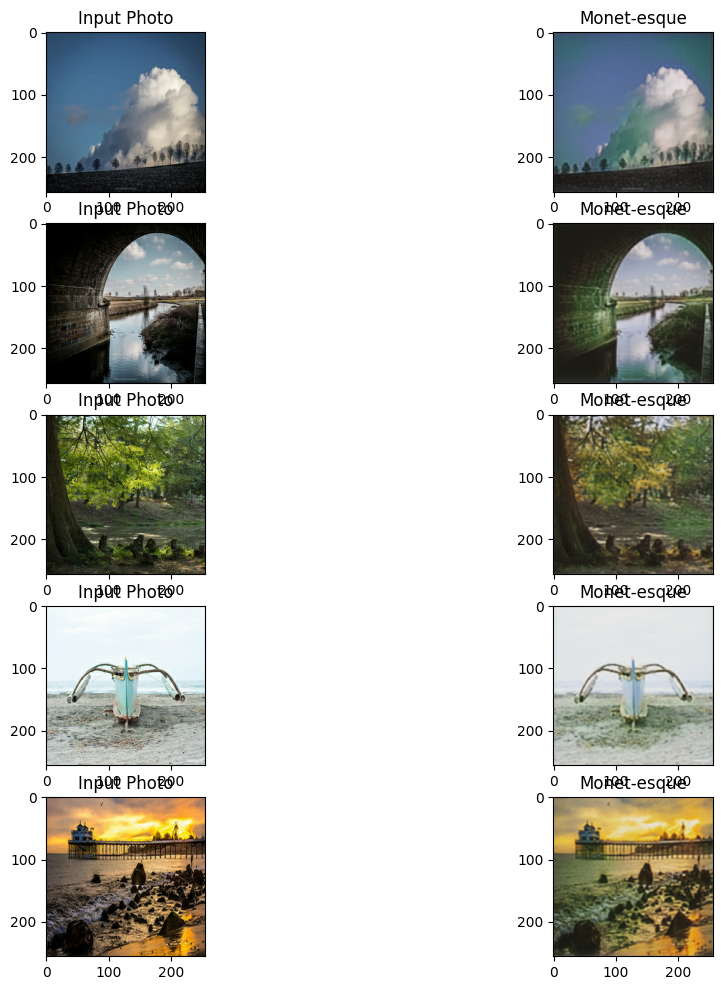

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_df.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i,0].imshow(img)
    ax[i,1].imshow(prediction)
    ax[i,0].set_title("Input Photo")
    ax[i,1].set_title("Monet-esque")
    #ax[i,0].axis("off")
    #ax[i,1].axis("off")